# cosmoglobe tutorial

Begin by importing some useful libraries:

In [1]:
import astropy.units as u
import healpy as hp
import numpy as np
import pathlib

To view plots inside the Jupyter Notebook:

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

## Initialize a sky model from a commander3 Gibbs chain

In this example we set the path to the chain file using the pathlib library

In [3]:
from cosmoglobe.sky import model_from_chain

chain_dir = pathlib.Path("/Users/metinsan/Documents/doktor/Cosmoglobe_test_data/")
chain = chain_dir / "chain_test.h5"

Initialize the model at a given ``nside``, for example ``nside=256``

In [4]:
# Reads alms and maps from the chain and initializes the sky model
model = model_from_chain(chain, nside=256)

Loading components from chain
Done: 100%|██████████| 6/6 [00:05<00:00,  1.14it/s] 


We can inspect the model by printing the model object. This shows us the individual sky components included in the model and their associated spectral parameters.

In [5]:
model

Model(
  nside: 256
  components( 
    (dust): ModifiedBlackBody(beta, T)
    (synch): PowerLaw(beta)
    (ff): FreeFree(Te)
    (ame): SpDust2(nu_p)
    (cmb): CMB()
    (radio): Radio(specind)
  )
)

## Model components

Let us explore the sky components in further detail. Each component is stored as a model attribute with attribute names seen in the parenthesis in the model `__repr__`.

In [6]:
model.dust

ModifiedBlackBody(beta, T)

In [7]:
model.synch

PowerLaw(beta)

### Component attributes

Each component has the following attributes:
- `amp`: amplitude map at a given reference frequency
- `freq_ref`: reference frequency
- `spectral_parameters`: dictionary containing the spectral parameters

In [8]:
# Note: most maps and other quantities are astropy.Quantity objects
print(model.dust.amp)
print(model.dust.freq_ref)
print(model.dust.spectral_parameters)

[[ 30.309875   -0.4310924   8.452302  ...   6.667059    9.971937
   11.81585  ]
 [ -7.411621  -10.035628  -11.562414  ... -14.917467   -9.604878
   -7.7464356]
 [ -2.512071    1.8047259   0.2342033 ...   1.374285    6.6490765
    2.7721624]] uK
[[545.]
 [353.]
 [353.]] GHz
{'beta': <Quantity [[1.5476462],
           [1.5766188],
           [1.5766188]]>, 'T': <Quantity [[17.331007],
           [17.331007],
           [17.331007]] K>}


We can visualize `amp` using healpy:

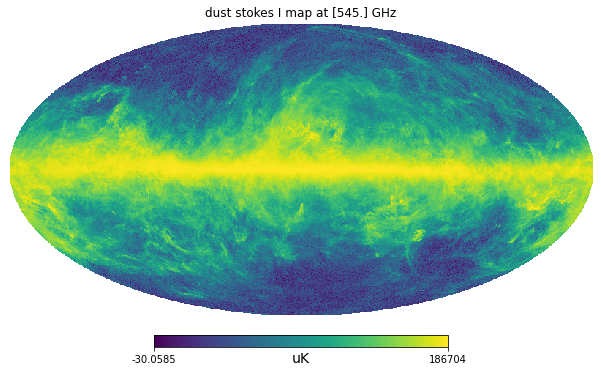

In [9]:
hp.mollview(
    model.dust.amp[0], # Stokes I map
    title=f'{model.dust.label} stokes I map at {model.dust.freq_ref[0]}', 
    norm='hist', 
    unit=model.dust.amp.unit # uK = uK_RJ
)

Similarely for Stokes Q:

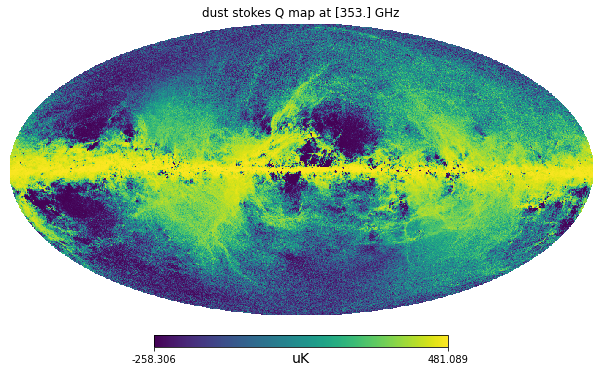

In [10]:
hp.mollview(
    model.dust.amp[1], 
    title=f'{model.dust.label} stokes Q map at {model.dust.freq_ref[1]}', 
    norm='hist', 
    unit=model.dust.amp.unit
)

## Simulations

We can simulate the emission from a component at some other frequency by calling the components `__call__` method:

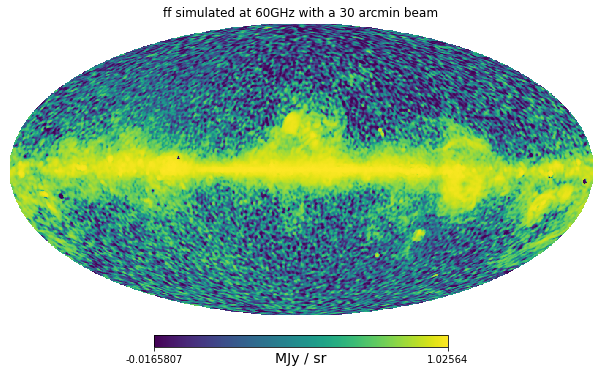

In [11]:
# simulated free free emission at 60GHz seen by a 30 arcmin beam in units of MJy/sr
ff_60GHz = model.ff(60*u.GHz, fwhm=30*u.arcmin, output_unit='MJy/sr')
hp.mollview(
    ff_60GHz[0], 
    title=f'ff simulated at 60GHz with a 30 arcmin beam', 
    norm='hist', 
    unit=ff_60GHz.unit
)

## Full sky model emission 

Similarely, by calling the model's `__call__` function, we can simulate the sky emission over the full model at a given frequency:

100%|██████████| 12192/12192 [00:02<00:00, 5033.98it/s]
Smoothing diffuse emission


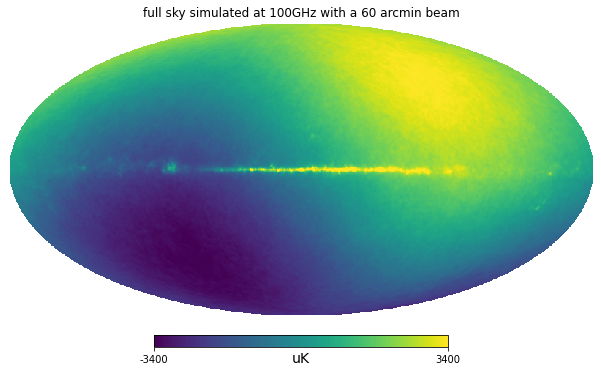

In [12]:
# simulated full sky emission at 100GHz seen by a 60 arcmin beam in units of uK_RJ
fullsky_emission_100GHz = model(100*u.GHz, fwhm=60*u.arcmin)
hp.mollview(
    fullsky_emission_100GHz[0], 
    title=f'full sky simulated at 100GHz with a 60 arcmin beam', 
    norm='hist', 
    min=-3400,
    max=3400,
    unit=fullsky_emission_100GHz.unit # by default, all emissions will have units of uK_RJ
)


Without the solar dipole:

100%|██████████| 12192/12192 [00:02<00:00, 4908.27it/s]
Smoothing diffuse emission


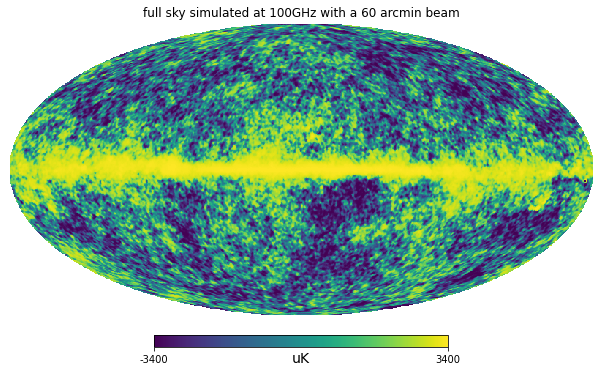

In [13]:
model.cmb.remove_dipole() # remove the solar dipole

# Note: we are using norm=hist but this isnt reflected in the colorbar in Jupyter
fullsky_emission_100GHz = model(100*u.GHz, fwhm=60*u.arcmin)
hp.mollview(
    fullsky_emission_100GHz[0], 
    title=f'full sky simulated at 100GHz with a 60 arcmin beam', 
    norm='hist', 
    min=-3400,
    max=3400,
    unit=fullsky_emission_100GHz.unit
)

## Bandpass integration

We can also make simulations over a given bandpass. In the following example we use the WMAP K-band bandpass profile:

In [14]:
data_dir = pathlib.Path("/Users/metinsan/Documents/doktor/Cosmoglobe/cosmoglobe/data/")
bandpass = chain_dir / "wmap_bandpass.txt"

frequencies, bandpass, _ = np.loadtxt(bandpass, unpack=True)
#add astropy units
frequencies*= u.GHz
bandpass *= u.K

100%|██████████| 12192/12192 [00:02<00:00, 4544.51it/s]
Smoothing diffuse emission


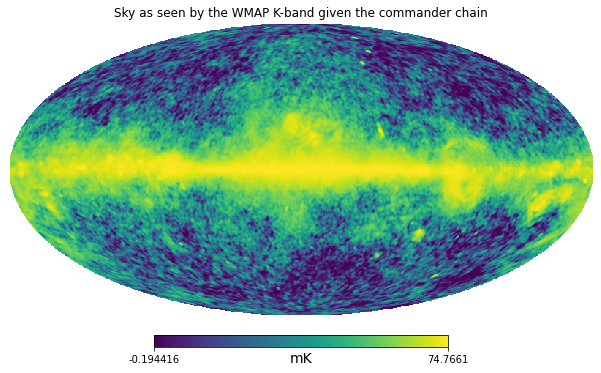

In [15]:
wmap_fwhm = 0.88*u.deg # WMAP observed with a beam of 0.88 degrees

# Note: Solar dipole is removed from the model emission
wmap_kband_emission = model(frequencies, bandpass, fwhm=60*u.arcmin, output_unit='mK')
hp.mollview(
    wmap_kband_emission[0], 
    title=f'Sky as seen by the WMAP K-band given the commander chain', 
    norm='hist', 
    unit=wmap_kband_emission.unit
)

## Point sources

The radio component do not internally store amplitude maps, but rather just a single amplitude value estimated in commander per pointsource. Each source is mapped to a healpix map with a gaussian beam whenever the model (or radio component) is called.

100%|██████████| 12192/12192 [00:02<00:00, 5402.09it/s]


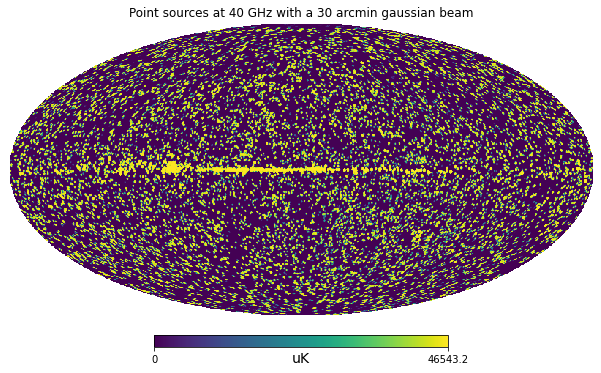

In [16]:
# Point sources seen at 40GHz over a 30 arcmin gaussian beam
radio_sources_40GHz = model.radio(30*u.GHz, fwhm=30*u.arcmin)
hp.mollview(
    radio_sources_40GHz[0], 
    title=f'Point sources at 40 GHz with a 30 arcmin gaussian beam', 
    norm='hist', 
    unit=radio_sources_40GHz.unit,
)

We can disable point sources (or any component in the model for that sake) as following:

In [17]:
model.disable('radio')

In [3]:
from cosmoglobe.plot import plot

ModuleNotFoundError: No module named 'plotly'

In [ ]:
plot